/cis/home/jteneggi/anaconda3/envs/cuda10/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cis/home/jteneggi/anaconda3/envs/cuda10/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


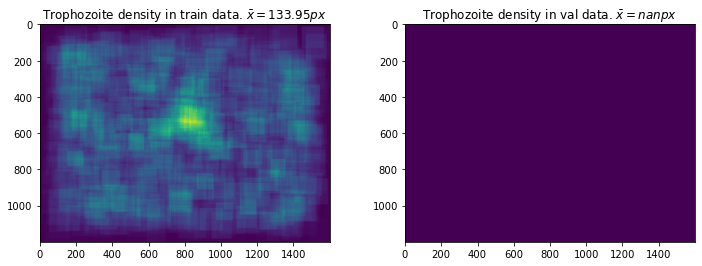

In [1]:
import os
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "/export/gaon1/data/jteneggi/data/malaria/trophozoite"

df_training = pd.read_json("/export/gaon1/data/jteneggi/data/malaria/training.json")

# ADD IMAGE_NAME COLUMN TO DATAFRAME
image_names = []
for i, row in df_training.iterrows():
    image_names.append(os.path.basename(row["image"]["pathname"]))
df_training["image_name"] = image_names

fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(1, 2)

# VISUALIZE POSITION OF TROPHOZOITES IN TRAIN AND VAL DATASET
x = ["train", "val"]
for k, stage in enumerate(x):
    ax = axes[k]
    TRAIN_DIR = os.path.join(DATA_DIR, stage)
    heatmap = np.zeros((1200, 1600))
    areas = []
    for root, _, files in os.walk(os.path.join(TRAIN_DIR, "1")):
        for image in files:
            image_heatmap = np.zeros((1200, 1600))
            area = 0
            query = df_training.loc[df_training["image_name"] == image]
            for i, row in query.iterrows():
                cells = row["objects"]
                for cell in cells:
                    cell_class = cell["category"]
                    if cell_class == "trophozoite":
                        bbox = cell["bounding_box"]
                        upper_left_r = bbox["minimum"]["r"]
                        upper_left_c = bbox["minimum"]["c"]
                        lower_right_r = bbox["maximum"]["r"]
                        lower_right_c = bbox["maximum"]["c"]
                        w = np.abs(lower_right_c - upper_left_c)
                        h = np.abs(lower_right_r - upper_left_r)
                        image_heatmap[upper_left_r:lower_right_r, upper_left_c:lower_right_c] = np.ones((h, w))
                        curr_area = h*w
                        areas.append(curr_area)
                        area += curr_area
                image_heatmap /= area
                heatmap += image_heatmap
    heatmap /= len(files)
    ax.imshow(heatmap)
    ax.set_title(r"Trophozoite density in %s data. $\bar{x} = %.2fpx$" % (stage, np.sqrt(np.mean(areas))))
plt.savefig("trophozoite_density.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


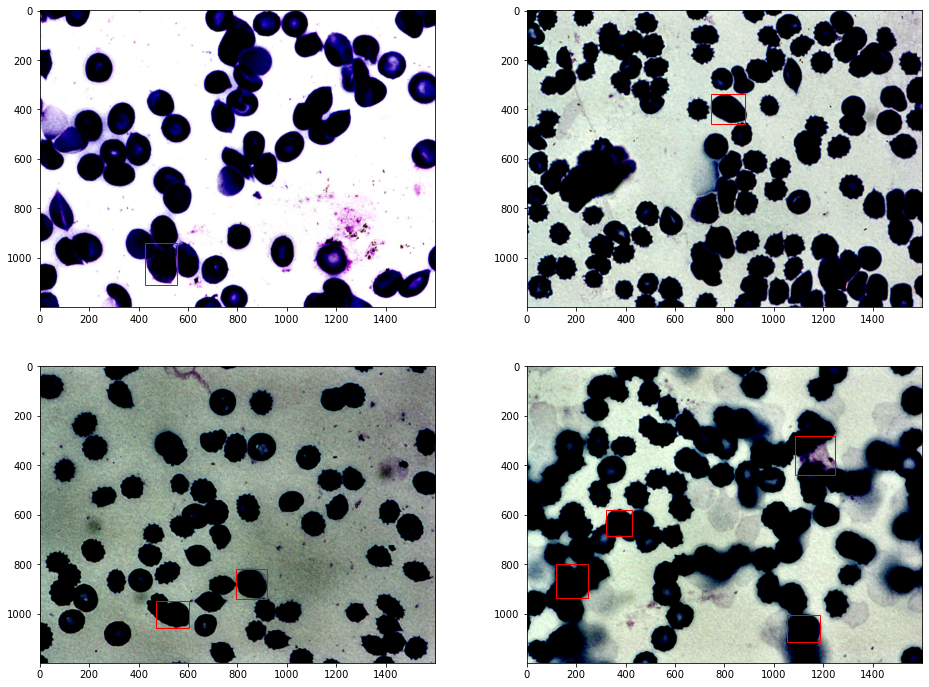

In [15]:
from PIL import Image
import matplotlib.patches as patches

fig = plt.figure(figsize=(16, 12))
axes = fig.subplots(2, 2)

test_data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.7325, 0.7314, 0.7406], [0.2412, 0.2424, 0.2398])
])

TRAIN_DIR = os.path.join(DATA_DIR, "train")
for root, _, files in os.walk(os.path.join(TRAIN_DIR, "1")):
        
        for i, image in enumerate(np.random.choice(files, size=4, replace=False)):
            img = Image.open(os.path.join(root, image))
            transformed_img = test_data_transform(img)
            ax = axes[int(i/2), i%2]
            ax.imshow(transformed_img.permute(1, 2, 0))
            query = df_training.loc[df_training["image_name"] == image]
            for i, row in query.iterrows():
                cells = row["objects"]
                for cell in cells:
                    cell_class = cell["category"]
                    if cell_class == "trophozoite":
                        bbox = cell["bounding_box"]
                        upper_left_r = bbox["minimum"]["r"]
                        upper_left_c = bbox["minimum"]["c"]
                        lower_right_r = bbox["maximum"]["r"]
                        lower_right_c = bbox["maximum"]["c"]
                        w = np.abs(lower_right_c - upper_left_c)
                        h = np.abs(lower_right_r - upper_left_r)
                        # Create a Rectangle patch
                        rect = patches.Rectangle((upper_left_c,upper_left_r),w,h,linewidth=1,edgecolor='r',facecolor='none')
                        # Add the patch to the Axes
                        ax.add_patch(rect)
plt.savefig("positive_examples.png")

tensor([1, 0, 0, 0])
torch.Size([4, 3, 1200, 1600])


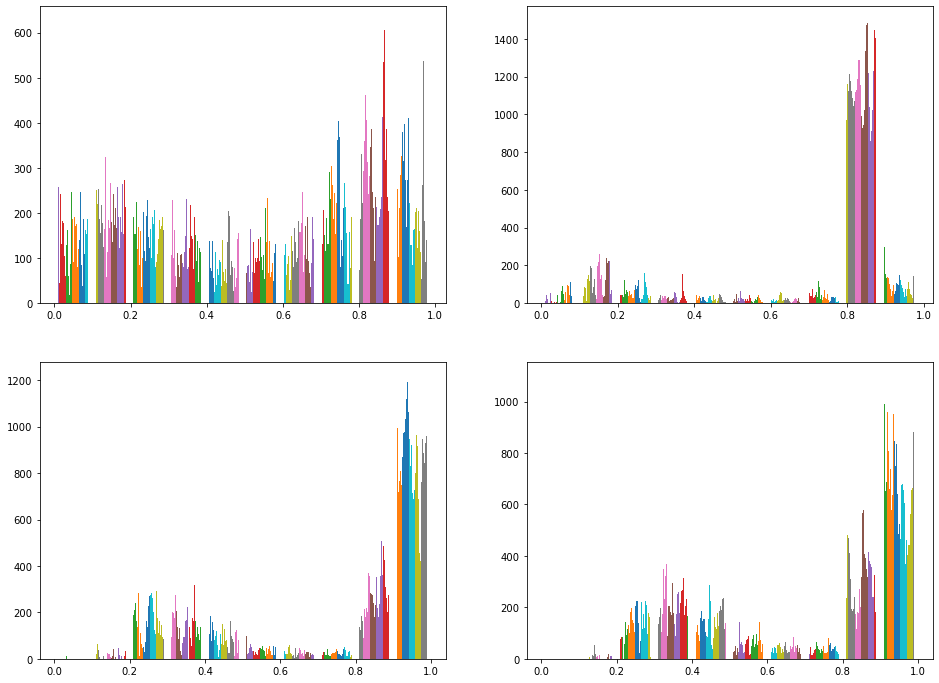

In [21]:
import torch
import torchvision
from torchvision import datasets, models, transforms

test_data_transform = transforms.Compose([
    transforms.ToTensor()
])

data_dir = "/export/gaon1/data/jteneggi/data/malaria/trophozoite"
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), test_data_transform)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, num_workers=4, shuffle=True)
images, labels = next(iter(dataloader))
print(labels)
print(images.shape)

fig = plt.figure(figsize=(16, 12))
axes = fig.subplots(2, 2)
for i, image in enumerate(images):
    ax = axes[int(i/2), i%2]
    ax.hist(image[0])